In [136]:
#Imports

import tensorflow as tf
import gradio as gr
import keras
import glob
import PIL
from PIL import Image

from keras import *
import numpy as np
import matplotlib.pyplot as plt


In [126]:
import pathlib

#Definere directory og klasser

dataset_directory = r"./Jellyfish"
data_dir = pathlib.Path(dataset_directory)

class_names = ['barrel_jellyfish','blue_jellyfish','compass_jellyfish','lions_mane_jellyfish','mauve_stinger_jellyfish','moon_jellyfish']


#Gir en verdi til labels
class_names_labels = {class_names:i for i,class_names in enumerate(class_names)}

print(class_names_labels)



{'barrel_jellyfish': 0, 'blue_jellyfish': 1, 'compass_jellyfish': 2, 'lions_mane_jellyfish': 3, 'mauve_stinger_jellyfish': 4, 'moon_jellyfish': 5}


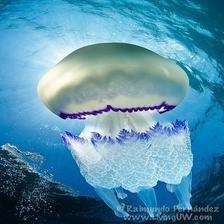

In [85]:
#Inspisere data

barrel_jellyfish = list(data_dir.glob('barrel_jellyfish/*'))
PIL.Image.open(str(barrel_jellyfish[1]))


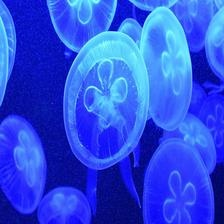

In [86]:
blue_jellyfish = list(data_dir.glob('blue_jellyfish/*'))
PIL.Image.open(str(blue_jellyfish[1]))

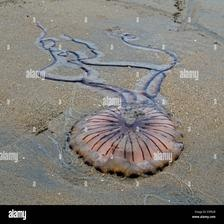

In [87]:
compass_jellyfish = list(data_dir.glob('compass_jellyfish/*'))
PIL.Image.open(str(compass_jellyfish[1]))

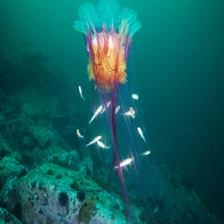

In [88]:
linos_mane_jellyfish = list(data_dir.glob('lions_mane_jellyfish/*'))
PIL.Image.open(str(linos_mane_jellyfish[1]))

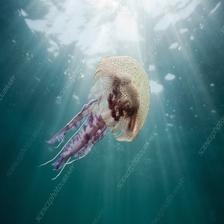

In [89]:

mauve_stinger_jellyfish = list(data_dir.glob('mauve_stinger_jellyfish/*'))
PIL.Image.open(str(mauve_stinger_jellyfish[1]))

In [127]:
print(data_dir)

Jellyfish


#TODO Fikse train_ds og val_ds ⬇️

Folder: Jellyfish\barrel_jellyfish
Folder: Jellyfish\blue_jellyfish
Folder: Jellyfish\compass_jellyfish
Folder: Jellyfish\lions_mane_jellyfish
Folder: Jellyfish\mauve_stinger_jellyfish
Folder: Jellyfish\Moon_jellyfish
Folder: Jellyfish\Train_Test_Valid


IndexError: list index out of range

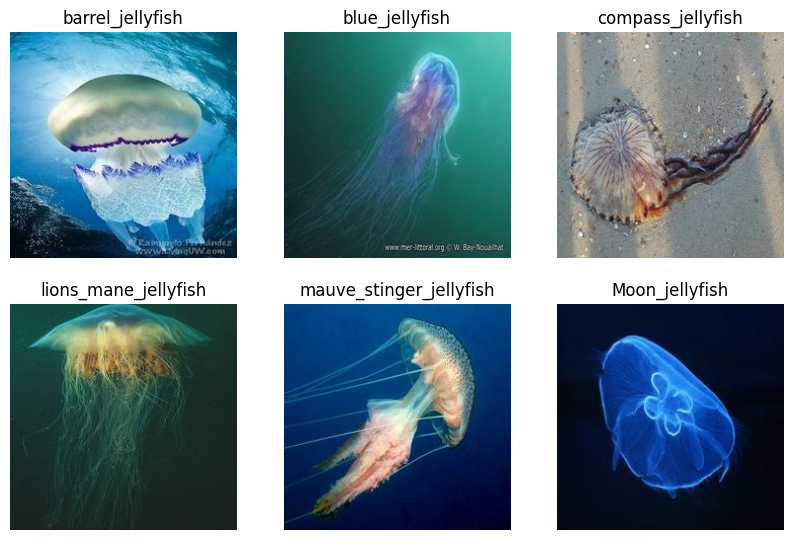

In [139]:
#Visualisere dataen

image_count = 1

plt.figure(figsize=(10, 10))
for folders in data_dir.glob('*/'):
    
    print(f"Folder: {folders}")
    image_files = list(folders.glob('*.jpg'))
    image_path = image_files[0]
    img = Image.open(image_path)
    ax = plt.subplot(3, 3, image_count)
    plt.imshow(img)
    plt.title(folders.name)
    plt.axis("off")
        
    image_count += 1  # Move to the next subplot
    

GRADIO NETTSIDE 

In [140]:

from click import launch

def greet(name, intensity):
    return "Hello, " + name + "!" * int(intensity)

demo = gr.Interface(
    fn=greet,
    inputs=["image", "slider"],
    outputs=["text"],
    
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
